# 11 空間構造のある階層ベイズモデル

In [1]:
using Distributed
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

In [2]:
using CSV
using DataFrames
using Distributed
using Distributions
using ForneyLab
using LinearAlgebra
@everywhere using Mamba
using Plots
using SparseArrays
using Statistics
using StatsBase

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl


## 11.1 例題 : 一次元空間上の個体数分布
### 例題の一次元空間上の架空データ

In [3]:
df = CSV.read("data/section11.csv")
disallowmissing!(df)

,y,m
,Int64,Float64
1,0,2.15498
2,3,3.25417
3,2,4.62867
4,5,6.23412
5,6,7.99073
6,16,9.79447
7,8,11.5334
8,14,13.1043
9,11,14.4263


横軸は調査区間の位置, 縦軸は観測された個体数, 破線はデータをポアソン乱数で生成するときに使った平均値

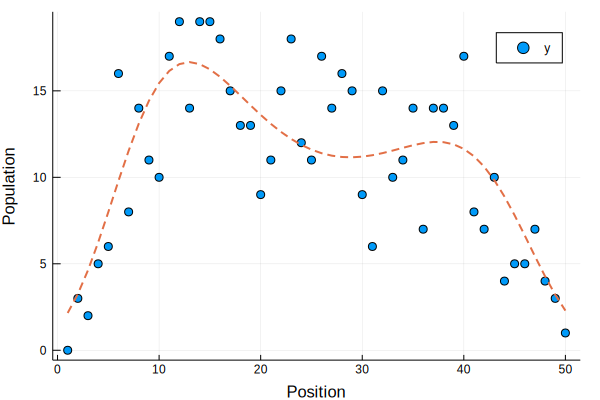

In [4]:
scatter(1:50, df.y, xlabel = "Position", ylabel = "Population", label = "y")
plot!(1:50, df.m, linewidth = 2, linestyle = :dash, label = "")

## 11.2 階層ベイズモデルに空間構造を組み込む
まず, 個体数$y_i$は, すべでの区画で共通する平均$\lambda$のポアソン分布に従うとしてみる.
\begin{align}
y_i & \sim \text{Poisson}(\lambda),\\
p(y_j \mid \lambda) & = \frac{\lambda^{y_i}\exp(-\lambda)}{y_j!}
\end{align}

このように仮定してすると, 平均$\lambda$と標本平均と等しいとしてみる.
### 標本平均

In [5]:
mean(df.y)

10.88

### 標本分散
ところが標本分散を求めてみると,

In [6]:
var(df.y)

27.373061224489796

となり, 標本平均の3倍近くなっている. そのため個体数が全ての区画で共通する平均$\lambda$のPoisson分布に従うと言う仮定は成立していなさそう.


そのため, 区間$j$ごとに平均$\lambda_i$が異なっているとし, 平均個体数を切片$\beta$と場所差$r_j$を用いて
\begin{align}
\log \lambda_i = \beta + r_j
\end{align}
と表す.
### 11.2.1. 空間構造のない階層事前分布
場所差$r_j$の事前分布を第10章で使ったような階層事前分布
\begin{align}
r_j & \sim \text{Normal}(0, s^2),\\
p(r_j \mid s) & = \frac{1}{\sqrt{2\pi s^2}}\exp \left( -\frac{r_j^2}{2s^2} \right)
\end{align}
であるとしてモデリングしてみる.

In [7]:
model1 = Model(

    y = Stochastic(1,
        (lambda, N) ->
            UnivariateDistribution[
            (Poisson(lambda[i])) for i in 1:N
        ],
        false
    ),
    
    lambda = Logical(1,
        (beta, r) -> exp.(beta .+ r)),
    
    beta = Stochastic(() -> Normal(0, 100)),
    
    r = Stochastic(1,
        (s, N) ->
            UnivariateDistribution[
            Normal(0, s) for _ in 1:N
        ],
        false
    ),
    
    s = Stochastic(() -> Uniform(0, 10000))
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


In [8]:
data1 = Dict{Symbol, Any}(
    :y => df.y,
    :N => length(df.y),
)

Dict{Symbol,Any} with 2 entries:
  :N => 50
  :y => [0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1]

In [9]:
inits1 = [
    Dict{Symbol, Any}(
        :y => df.y,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(df.y)),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[0.0372106, -0.122814, -0.0796836, -0.0206806, -0.0681248, 0.224497, -0.0613141, 0.039213, -0.0824183, -0.0100884  …  -0.069387, 0.118732, -0.0774331, 0.0643028, 0.0297261, 0.237462, -0.0410543, -0.0855662, -0.160596, -0.0402507])  
 Dict(:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[0.0684378, -0.138753, -0.0115597, -0.11521, -0.0308368, -0.0176501, 0.00747767, 0.0359196, 0.0401215, 0.0738594  …  -0.133146, -0.143907, 0.118995, 0.170252, -0.0184581, 0.178615, -0.133241, 0.0723909, -0.0470313, 0.0643515])      
 Dict(:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[0.0567406, 0.0172874, -0.134773, 0.0903914, -0.255385, -0.0563472, -0.132802, 0.0636345, 0.00479829, 0.000644512  …  0.0810328, 0.0133287, 0.147052, -0.00113085, 0.276933, -0.0109272, 0.0111

In [10]:
scheme1 = [
    Slice(:s, 1.0),
    Slice(:beta, 1.0),
    AMWG(:r, 1),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.SliceTune{Distributions.Multivariate}}"
Sampling Block Nodes:
Symbol[:s]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                                         
 An object of type "Sampler{Mamba.SliceTune{Distributions.Multivariate}}"
Sampling Block Nodes:
Symbol[:beta]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                 

In [11]:
setsamplers!(model1, scheme1)
sim1 = mcmc(model1, data1, inits1, 60000, burnin = 10000, thin = 10, chains = 3)

MCMC Simulation of 60000 Iterations x 3 Chains...

      From worker 4:	Chain 3:   0% [9:10:50 of 9:10:55 remaining]
      From worker 3:	Chain 2:   0% [9:30:10 of 9:30:16 remaining]
      From worker 2:	Chain 1:   0% [9:34:56 of 9:35:02 remaining]
      From worker 4:	Chain 3:  10% [0:03:07 of 0:03:28 remaining]
      From worker 3:	Chain 2:  10% [0:03:10 of 0:03:31 remaining]
      From worker 2:	Chain 1:  10% [0:03:09 of 0:03:30 remaining]
      From worker 2:	Chain 1:  20% [0:02:24 of 0:02:60 remaining]
      From worker 4:	Chain 3:  20% [0:02:24 of 0:03:00 remaining]
      From worker 3:	Chain 2:  20% [0:02:24 of 0:03:00 remaining]
      From worker 3:	Chain 2:  30% [0:01:58 of 0:02:49 remaining]
      From worker 2:	Chain 1:  30% [0:01:58 of 0:02:49 remaining]
      From worker 4:	Chain 3:  30% [0:01:59 of 0:02:49 remaining]
      From worker 3:	Chain 2:  40% [0:01:37 of 0:02:42 remaining]
      From worker 2:	Chain 1:  40% [0:01:38 of 0:02:43 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

[0.510746 2.29844 … 3.28678 8.58273; 0.51909 2.30024 … 2.6673 3.19584; … ; 0.498361 2.29507 … 4.02377 2.9733; 0.522884 2.33636 … 4.31943 3.63505]

[0.518653 2.20691 … 2.1766 4.25716; 0.627517 2.37635 … 4.89162 2.06342; … ; 0.493351 2.21672 … 3.65606 8.10034; 0.520114 2.16098 … 6.00683 2.42359]

[0.48734 2.21146 … 4.32288 6.04856; 0.50735 2.36558 … 6.97684 3.71718; … ; 0.425024 2.18624 … 7.08189 9.47538; 0.469376 2.38579 … 6.0315 5.14767]

In [12]:
describe(sim1)

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

Empirical Posterior Estimates:
               Mean         SD        Naive SE       MCSE      ESS
         s  0.45192615 0.082482199 0.00067346434 0.0009618677 5000
      beta  2.29904548 0.081163588 0.00066269792 0.0008993153 5000
 lambda[1]  4.43467215 1.635316593 0.01335230407 0.0155809266 5000
 lambda[2]  5.92268483 1.874723176 0.01530705064 0.0170607649 5000
 lambda[3]  5.40812147 1.799331832 0.01469148288 0.0163707364 5000
 lambda[4]  7.02144315 2.080630405 0.01698827612 0.0175343034 5000
 lambda[5]  7.63504188 2.169427486 0.01771330124 0.0181989179 5000
 lambda[6] 14.22039169 3.260700689 0.02662350964 0.0271353355 5000
 lambda[7]  8.79396163 2.387404061 0.01949307253 0.0204604476 5000
 lambda[8] 12.80141145 3.022431389 0.02467804895 0.0232827117 5000
 lambda[9] 10.77904887 2.723771094 0.02223949786 0.0241339890 5000
lambda[10] 10.09392278 2.593735362 0.02117776055 0.0212830192 5000
lambda[11

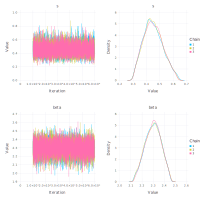

In [13]:
p1 = Mamba.plot(sim1, legend = true)
Mamba.draw(p1[:, 1:2], nrow = 2, ncol = 2)

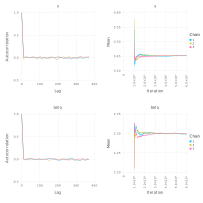

In [14]:
p2 = Mamba.plot(sim1, [:autocor, :mean], legend=true)
Mamba.draw(p2[:, 1:2], nrow = 2, ncol = 2)

$\lambda$の中央値、95%信頼区間をプロットしてみる

In [15]:
mre = quantile(sim1).value[3:end, :]

50×5 Array{Float64,2}:
  1.81766   3.25294   4.22801   5.42298   8.19519
  2.80278   4.58819   5.74305   7.02872  10.1435 
  2.46455   4.10726   5.21103   6.4935    9.39871
  3.59326   5.52888   6.81239   8.24574  11.7117 
  3.99848   6.07894   7.42709   8.97096  12.4468 
  8.66653  11.8771   13.9742   16.2097   21.4183 
  4.80697   7.08303   8.56642  10.2602   14.115  
  7.72061  10.6087   12.5423   14.681    19.3592 
  6.18835   8.83612  10.5011   12.4296   16.8297 
  5.7646    8.25386   9.84458  11.6678   15.8726 
  9.36199  12.6197   14.6971   17.1419   22.4364 
 10.2659   13.8785   16.1182   18.6877   24.4319 
  7.70743  10.6536   12.5383   14.7149   19.5869 
  ⋮                                              
  7.17088  10.0314   11.9146   14.0018   18.6702 
  9.15471  12.5655   14.7078   17.0552   22.5237 
  4.92092   7.16258   8.61861  10.2947   14.1871 
  4.39444   6.56515   7.97898   9.60496  13.3001 
  5.72229   8.24773   9.85599  11.6528   15.9466 
  3.17069   5.05288   6.250

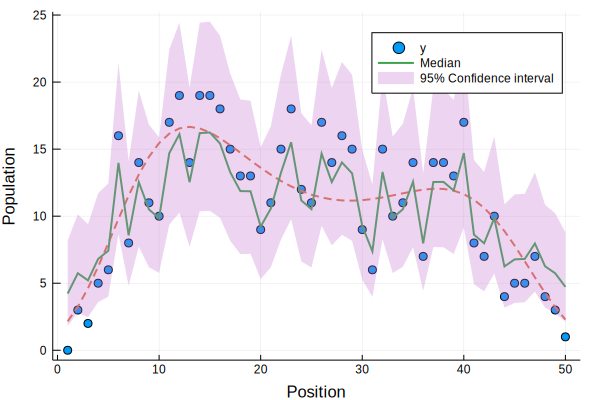

In [16]:
scatter(1:50, df.y, xlabel = "Position", ylabel = "Population", label = "y")
plot!(1:50, df.m, linewidth = 2, linestyle = :dash, label = "")
plot!(1:50, mre[:, 3], linewidth = 2, label = "Median")
plot!(1:50, mre[:, 1], lw = 0, 
    fillrange = mre[:, 5],
    fillalpha = 0.3, 
    label = "95% Confidence interval")

### 11.2.2 空間構造のある階層事前分布
ある区間はそれと隣接する区間とだけ相互作用すると仮定する. 
近傍数は$n_j = 2 \ (j \neq 1, 50), 1 \ (j = 1, 50)$となる.

\begin{align}
\mu_j & = \frac{r_{j-1} + r_{j+1}}{2}\ (j \neq 1, 50), \mu_1 = r_2, \mu_{50} = r_{49},\\
r_j \mid \mu_j, s & \sim \text{Normal}\left(\mu_j, \frac{s}{\sqrt{n_j}}\right)
\end{align}
と言うモデルを考える.
## 11.3 空間統計モデルをデータに当てはめる
CARモデルを実装する。
参考 : https://github.com/matsueushi/lip_stick_mamba

In [17]:
model2 = Model(

    y = Stochastic(1,
        (lambda, N) ->
            UnivariateDistribution[
            (Poisson(lambda[i])) for i in 1:N
        ],
        false
    ),
    
    lambda = Logical(1,
        (beta, r) -> exp.(beta .+ r)),
    
    beta = Stochastic(() -> Normal(0, 100)),
    
    r = Stochastic(1,
        (s, alpha, N, D, adj) ->
            MvNormalCanon(zeros(N), 1 / (s * s) * (D - alpha * adj)),
        false
    ),
    
    alpha = Stochastic(() -> Uniform()),
    
    s = Stochastic(() -> Uniform(0, 10000))
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
alpha:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


In [18]:
adj = spzeros(50, 50)
for i in 1:50-1
    adj[i, i+1] = 1
    adj[i+1, i] = 1
end
adj

50×50 SparseMatrixCSC{Float64,Int64} with 98 stored entries:
  [2 ,  1]  =  1.0
  [1 ,  2]  =  1.0
  [3 ,  2]  =  1.0
  [2 ,  3]  =  1.0
  [4 ,  3]  =  1.0
  [3 ,  4]  =  1.0
  [5 ,  4]  =  1.0
  [4 ,  5]  =  1.0
  [6 ,  5]  =  1.0
  [5 ,  6]  =  1.0
  [7 ,  6]  =  1.0
  [6 ,  7]  =  1.0
  ⋮
  [45, 44]  =  1.0
  [44, 45]  =  1.0
  [46, 45]  =  1.0
  [45, 46]  =  1.0
  [47, 46]  =  1.0
  [46, 47]  =  1.0
  [48, 47]  =  1.0
  [47, 48]  =  1.0
  [49, 48]  =  1.0
  [48, 49]  =  1.0
  [50, 49]  =  1.0
  [49, 50]  =  1.0

In [19]:
D = Diagonal(vec(sum(adj, dims=2)))

50×50 Diagonal{Float64,Array{Float64,1}}:
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   2.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   2.0   ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   2.0   ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   2.0   ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   2.0   ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   2.0   ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   2.0      ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    

In [20]:
data2 = Dict{Symbol, Any}(
    :y => df.y,
    :N => length(df.y),
    :adj => adj,
    :D => D,
)

Dict{Symbol,Any} with 4 entries:
  :N   => 50
  :adj => …
  :y   => [0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1]
  :D   => [1.0 0.0 … 0.0 0.0; 0.0 2.0 … 0.0 0.0; … ; 0.0 0.0 … 2.0 0.0; 0.0 0.0…

In [21]:
inits2 = [
    Dict{Symbol, Any}(
        :y => df.y,
        :alpha => 0.5,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(df.y)),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:alpha=>0.5,:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[-0.158697, 0.0742136, 0.0270043, 0.0194161, -0.0766017, 0.0907147, -0.0505204, 0.032602, 0.0512243, -0.137538  …  -0.07023, 0.0215474, -0.0331764, -0.331778, 0.122069, 0.112325, 0.214697, -0.156883, 0.160495, 0.153198])   
 Dict(:alpha=>0.5,:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[0.0555456, -0.00493468, 0.0851429, -0.171165, 0.0885816, -0.0808543, 0.040291, 0.0234286, 0.156881, 0.0442612  …  0.07715, -0.12485, 0.0818788, 0.0601773, 0.081094, 0.00227223, 0.0692238, 0.0194705, -0.051814, 0.00766977])
 Dict(:alpha=>0.5,:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[0.139885, 0.020027, 0.013576, 0.035493, 0.158982, 0.0874995, -0.143526, -0.0775715, -0.0217132, 0.0530867  …  -0.00427327, 0.0198981, 0.146586, -0.104843, 0.138278, -0.0260

In [22]:
scheme2 = [
    Slice(:s, 1.0),
    Slice([:alpha, :beta], 1.0),
    AMWG(:r, 1),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.SliceTune{Distributions.Multivariate}}"
Sampling Block Nodes:
Symbol[:s]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                                         
 An object of type "Sampler{Mamba.SliceTune{Distributions.Multivariate}}"
Sampling Block Nodes:
Symbol[:alpha, :beta]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                         

In [23]:
setsamplers!(model2, scheme2)
sim2 = mcmc(model2, data2, inits2, 60000, burnin = 10000, thin = 10, chains = 3)

MCMC Simulation of 60000 Iterations x 3 Chains...

      From worker 4:	Chain 2:   0% [0:26:54 of 0:26:54 remaining]
      From worker 2:	Chain 1:   0% [0:29:48 of 0:29:48 remaining]
      From worker 3:	Chain 3:   0% [0:30:50 of 0:30:50 remaining]
      From worker 4:	Chain 2:  10% [0:03:31 of 0:03:54 remaining]
      From worker 3:	Chain 3:  10% [0:03:31 of 0:03:55 remaining]
      From worker 2:	Chain 1:  10% [0:03:35 of 0:03:59 remaining]
      From worker 4:	Chain 2:  20% [0:03:03 of 0:03:49 remaining]
      From worker 3:	Chain 3:  20% [0:03:05 of 0:03:51 remaining]
      From worker 2:	Chain 1:  20% [0:03:05 of 0:03:51 remaining]
      From worker 4:	Chain 2:  30% [0:02:43 of 0:03:54 remaining]
      From worker 3:	Chain 3:  30% [0:02:45 of 0:03:55 remaining]
      From worker 2:	Chain 1:  30% [0:02:45 of 0:03:56 remaining]
      From worker 4:	Chain 2:  40% [0:02:19 of 0:03:52 remaining]
      From worker 3:	Chain 3:  40% [0:02:20 of 0:03:53 remaining]
      From worker 2:	Chai

Object of type "ModelChains"

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

[0.281088 0.987076 … 2.49784 1.54727; 0.279117 0.986794 … 4.30947 3.34338; … ; 0.273523 0.986914 … 2.89271 2.27176; 0.249519 0.994607 … 2.60092 1.79046]

[0.332032 0.988322 … 4.09865 2.70608; 0.222724 0.99912 … 3.20792 3.17316; … ; 0.316456 0.986063 … 4.35245 3.4702; 0.266617 0.967834 … 5.87385 3.2495]

[0.332587 0.950169 … 1.7872 2.13015; 0.37699 0.95081 … 3.47308 2.51139; … ; 0.300859 0.965007 … 5.42921 6.12571; 0.300251 0.978667 … 3.4811 2.80439]

In [24]:
describe(sim2)

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

Empirical Posterior Estimates:
               Mean         SD        Naive SE        MCSE         ESS   
         s  0.28738931 0.070028848 0.00057178315 0.00106519959 4322.07186
     alpha  0.97551478 0.027663828 0.00022587421 0.00051534426 2881.57328
      beta  2.32007035 0.290201098 0.00236948205 0.01903973669  232.31445
 lambda[1]  2.85238145 1.085825785 0.00886573041 0.01593522691 4643.05467
 lambda[2]  3.42062293 1.069422695 0.00873179974 0.01628344112 4313.26774
 lambda[3]  4.04622567 1.133166054 0.00925226209 0.01736413156 4258.73853
 lambda[4]  5.39937515 1.326403821 0.01083004185 0.01739257613 5000.00000
 lambda[5]  7.24864147 1.616742236 0.01320064508 0.01697067976 5000.00000
 lambda[6] 10.71106621 2.274108730 0.01856802003 0.02566298299 5000.00000
 lambda[7] 10.20391914 2.030323182 0.01657751936 0.01963880491 5000.00000
 lambda[8] 11.86608007 2.317744062 0.01892430102 0.02063840080 500

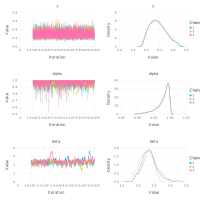

In [25]:
p3 = Mamba.plot(sim2, legend = true)
Mamba.draw(p3[:, 1:3], nrow = 3, ncol = 2)

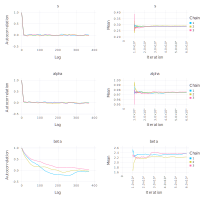

In [26]:
p4 = Mamba.plot(sim2, [:autocor, :mean], legend=true)
Mamba.draw(p4[:, 1:3], nrow = 3, ncol = 2)

In [27]:
mre2 = quantile(sim2).value[4:end, :]

50×5 Array{Float64,2}:
  1.13767   2.06989   2.72354   3.48915   5.37245
  1.64765   2.65754   3.31641   4.06161   5.82975
  2.14139   3.23332   3.94848   4.7431    6.56149
  3.1431    4.46047   5.28085   6.20469   8.30398
  4.46357   6.11454   7.08389   8.24852  10.7394 
  6.9923    9.11403  10.4542   12.0546   15.8207 
  6.67844   8.78519  10.034    11.4625   14.62   
  7.93097  10.2273   11.6578   13.2739   16.9617 
  7.79882  10.082    11.4767   13.0349   16.5165 
  7.99873  10.5438   11.9932   13.5784   17.0053 
 10.5099   13.314    15.0221   16.9111   21.0129 
 11.6378   14.6562   16.5408   18.6154   23.3464 
 10.8509   13.8233   15.5492   17.4555   21.8207 
  ⋮                                              
  8.74405  11.2786   12.7731   14.4467   18.2328 
  8.81186  11.299    12.8568   14.593    18.7299 
  6.30829   8.33402   9.56702  10.9348   13.9953 
  5.2907    7.11045   8.21227   9.4764   12.2845 
  5.01127   6.71604   7.76038   8.97134  11.9262 
  3.76765   5.22165   6.108

### Plotting

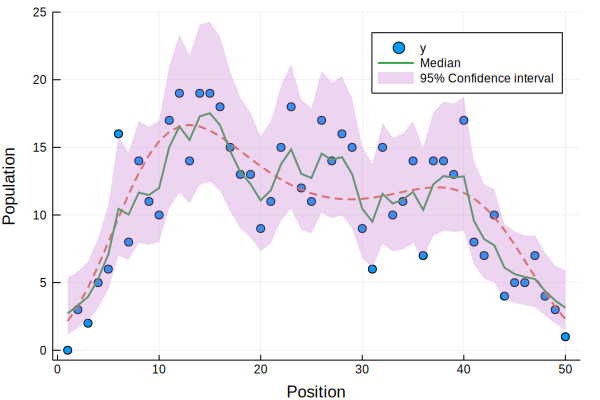

In [28]:
scatter(1:50, df.y, xlabel = "Position", ylabel = "Population", label = "y")
plot!(1:50, df.m, linewidth = 2, linestyle = :dash, label = "")
plot!(1:50, mre2[:, 3], linewidth = 2, label = "Median")
plot!(1:50, mre2[:, 1], lw = 0, 
    fillrange = mre2[:, 5],
    fillalpha = 0.3, 
    label = "95% Confidence interval")